# Image Segmentation with `tf.keras`

In this tutorial we will learn how to segment images. **Segmentation** is the process of generating pixel-wise segmentations giving the class of the object visible at each pixel. For example, we could be identifying the location and boundaries of people within an image or identifying cell nuclei from an image. Formally, image segmentation refers to the process of partitioning an image into a set of pixels that we desire to identify (our target) and the background. 

Specifically, in this tutorial we will be using the [Kaggle Carvana Image Masking Challenge Dataset](https://www.kaggle.com/c/carvana-image-masking-challenge). 

This dataset contains a large number of car images, with each car taken from different angles. In addition, for each car image, we have an associated manually cutout mask; our task will be to automatically create these cutout masks for unseen data. 

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts:
* **[Functional API](https://keras.io/getting-started/functional-api-guide/)** - we will be implementing UNet, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * Check out the original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger!
* **Distributed Learning with [Analytics Zoo](https://analytics-zoo.github.io/)** - We will introduce distributed training for our keras model using Analytics Zoo.
* **Custom Loss Functions and Metrics** - We'll implement a custom loss function using binary [**cross entropy**](https://developers.google.com/machine-learning/glossary/#cross-entropy) and **dice loss**. We'll also implement **dice coefficient** (which is used for our loss) and **mean intersection over union**, that will help us monitor our training process and judge how well we are performing. 
* **Saving and loading keras models** - We'll save our best model to disk. When we want to perform inference/evaluate our model, we'll load in the model from disk. 

### We will follow the general workflow:
1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat


In [1]:
!pip install kaggle

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

# Get all the files 
Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api#api-credentials) for your Kaggle account, and uploading it. 

In [4]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()


Only import kaggle after adding the credentials.

In [5]:
import kaggle

### We'll download the data from Kaggle
Caution, large download ahead - downloading all files will require 14GB of diskspace. 

In [6]:
competition_name = 'carvana-image-masking-challenge'

In [7]:
# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')


You must [accept the competition rules](https://www.kaggle.com/c/carvana-image-masking-challenge/rules) before downloading the data.

In [8]:
get_data(competition_name)

In [9]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [10]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [11]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [12]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [13]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


### Here's what the paths look like 

In [14]:
x_train_filenames[:10]

['carvana-image-masking-challenge/train/69915dab0755_16.jpg',
 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg',
 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg',
 'carvana-image-masking-challenge/train/562706000bd7_15.jpg',
 'carvana-image-masking-challenge/train/917f262f1608_06.jpg',
 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg',
 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg',
 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg',
 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg',
 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']

In [15]:
y_train_filenames[:10]

['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif',
 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif',
 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif',
 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif',
 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif',
 'carvana-image-masking-challenge/train_masks/fce0ba5b8ed7_07_mask.gif',
 'carvana-image-masking-challenge/train_masks/93881caf9f70_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/eb07e3f63ad2_09_mask.gif',
 'carvana-image-masking-challenge/train_masks/78bfb9c780db_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/d3d0d2662918_12_mask.gif']

# Visualize
Let's take a look at some of the examples of different images in our dataset. 

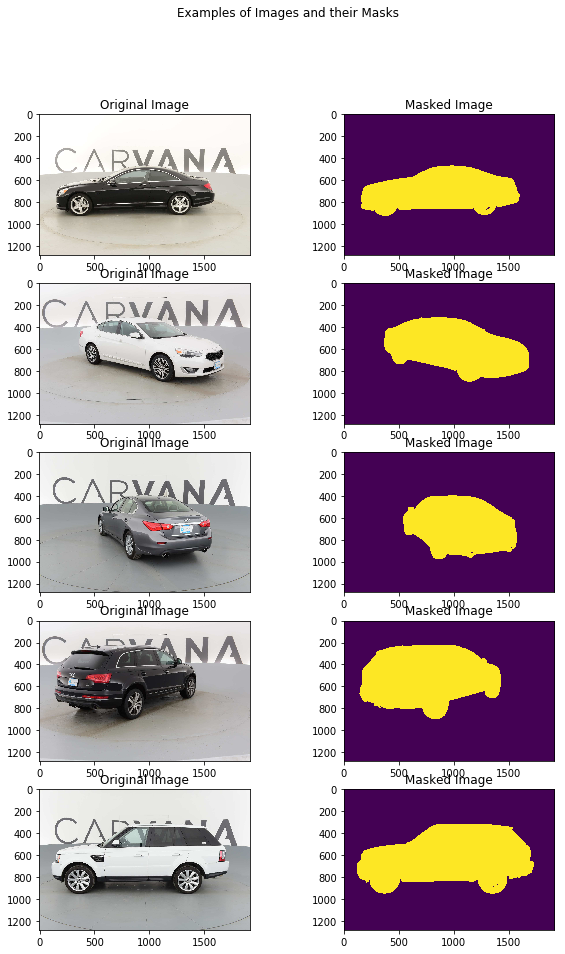

In [16]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up 

Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters: 

In [17]:
img_shape = (256, 256, 3)
batch_size = 280
epochs = 1

Using these exact same parameters may be too computationally intensive for your hardware, so tweak the parameters accordingly. Also, it is important to note that due to the architecture of our UNet version, the size of the image must be evenly divisible by a factor of 32, as we down sample the spatial resolution by a factor of 2 with each `MaxPooling2Dlayer`.


If your machine can support it, you will achieve better performance using a higher resolution input image (e.g. 512 by 512) as this will allow more precise localization and less loss of information during encoding. In addition, you can also make the model deeper.


Alternatively, if your machine cannot support it, lower the image resolution and/or batch size. Note that lowering the image resolution will decrease performance and lowering batch size will increase training time.


# Build our input pipeline with `tf.data`
Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. If you are unfamiliar with **tf.data** you should check out my other tutorial introducing the concept! 

### Our input pipeline will consist of the following steps:
1. Read the bytes of the file in from the filename - for both the image and the label. Recall that our labels are actually images with each pixel annotated as car or background (1, 0). 
2. Decode the bytes into an image format
3. Apply image transformations: (optional, according to input parameters)
  * `resize` - Resize our images to a standard size (as determined by eda or computation/memory restrictions)
    * The reason why this is optional is that U-Net is a fully convolutional network (e.g. with no fully connected units) and is thus not dependent on the input size. However, if you choose to not resize the images, you must use a batch size of 1, since you cannot batch variable image size together
    * Alternatively, you could also bucket your images together and resize them per mini-batch to avoid resizing images as much, as resizing may affect your performance through interpolation, etc.
  * `hue_delta` - Adjusts the hue of an RGB image by a random factor. This is only applied to the actual image (not our label image). The `hue_delta` must be in the interval `[0, 0.5]` 
  * `horizontal_flip` - flip the image horizontally along the central axis with a 0.5 probability. This transformation must be applied to both the label and the actual image. 
  * `width_shift_range` and `height_shift_range` are ranges (as a fraction of total width or height) within which to randomly translate the image either horizontally or vertically. This transformation must be applied to both the label and the actual image. 
  * `rescale` - rescale the image by a certain factor, e.g. 1/ 255.
4. Shuffle the data, repeat the data (so we can iterate over it multiple times across epochs), batch the data, then prefetch a batch (for efficiency).

It is important to note that these transformations that occur in your data pipeline must be symbolic transformations. 

#### Why do we do these image transformations?
This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

## Processing each pathname

In [18]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

## Shifting the image

In [19]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

## Flipping the image randomly 

In [20]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

## Assembling our transformations into our augment function

In [21]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

In [22]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [23]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [24]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [25]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=num_train_examples)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=num_val_examples)

## Let's see if our image augmentor data pipeline is producing expected results

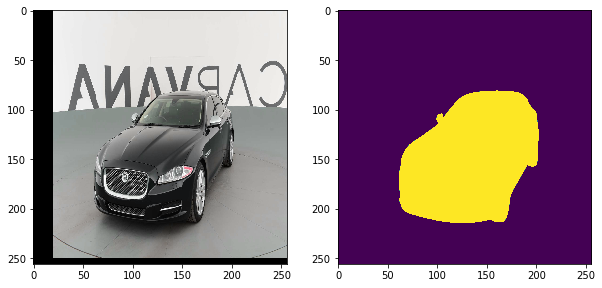

In [26]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

# Build the model
We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 
## The Keras Functional API
The Keras functional API is used when you have multi-input/output models, shared layers, etc. It's a powerful API that allows you to manipulate tensors and build complex graphs with intertwined datastreams easily. In addition it makes **layers** and **models** both callable on tensors. 
  * To see more examples check out the [get started guide](https://keras.io/getting-started/functional-api-guide/). 
  
  
  We'll build these helper functions that will allow us to ensemble our model block operations easily and simply. 

In [27]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [28]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

## Define your model
Using functional API, you must define your model by specifying the inputs and outputs associated with the model. 

In [29]:
model = models.Model(inputs=[inputs], outputs=[outputs])

# Defining custom metrics and loss functions
Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example. 

Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced. 

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly. 

In [30]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [31]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [32]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile your model
We use our custom loss function to minimize. In addition, we specify what metrics we want to keep track of as we train. Note that metrics are not actually used during the training process to tune the parameters, but are instead used to measure performance of the training process. 

In [33]:
model.compile(optimizer='adam', loss=bce_dice_loss)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

## Train your model with Analytics Zoo
Training your model with Analytics Zoo involves warpping your Keras model with `zoo.tfpark.KerasModel`, prefetching training/validation data from `tf.Dataset`, and providing the model's `fit` function with prefetched training/validation data, the number of steps, and epochs.

In [34]:
save_model_path = '/tmp/weights.hdf5'

# prefetch our training/validation data into memory for distributed training
data_aug_iter = train_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# prefetch our training data
with tf.Session() as sess:
  x_train_data, y_train_data = sess.run(next_element)

# prefetch our validation data
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess:
  x_val_data, y_val_data = sess.run(next_element)

Don't forget to save our model after training!

Note that saving the model capture more than just the weights of the model: by default, it saves the model architecture, weights, as well as information about the training process such as the state of the optimizer, etc.

In [35]:
from zoo import init_nncontext
from zoo.tfpark import KerasModel
_ = init_nncontext()
# Wrapped Keras model with Analytics Zoo api
model = KerasModel(model)
model.fit(x_train_data,
          y_train_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val_data, y_val_data),
          distributed=True)

model.save_model(save_model_path)


Using /usr/local/spark-2.1.0-bin-hadoop2.6
Prepending /usr/local/spark-2.1.0-bin-hadoop2.6/python/lib/py4j-0.10.4-src.zip to sys.path
Prepending /usr/local/spark-2.1.0-bin-hadoop2.6/python/lib/pyspark.zip to sys.path
Prepending /home/bozhou/.pyenv/versions/3.5.4/lib/python3.5/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
creating: createAdam
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 164 variables.
INFO:tensorflow:Converted 164 variables to const ops.
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createMaxEpoch


Note that for illustration, we only run 1 epoch and hence the performance is limited. If you run more epochs like `epochs=5`, you might get more wonderful visualization output.

# Visualize actual performance 
We'll visualize our performance on the validation set.

Note that in an actual setting (competition, deployment, etc.) we'd evaluate on the test set with the full image resolution. 

To load our model we have two options:
1. Since our model architecture is already in memory, we can simply call `load_weights(save_model_path)`
2. If you wanted to load the model from scratch (in a different setting without already having the model architecture in memory) we simply call 

```model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})```, specificing the necessary custom objects, loss and metrics, that we used to train our model. 

In [37]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

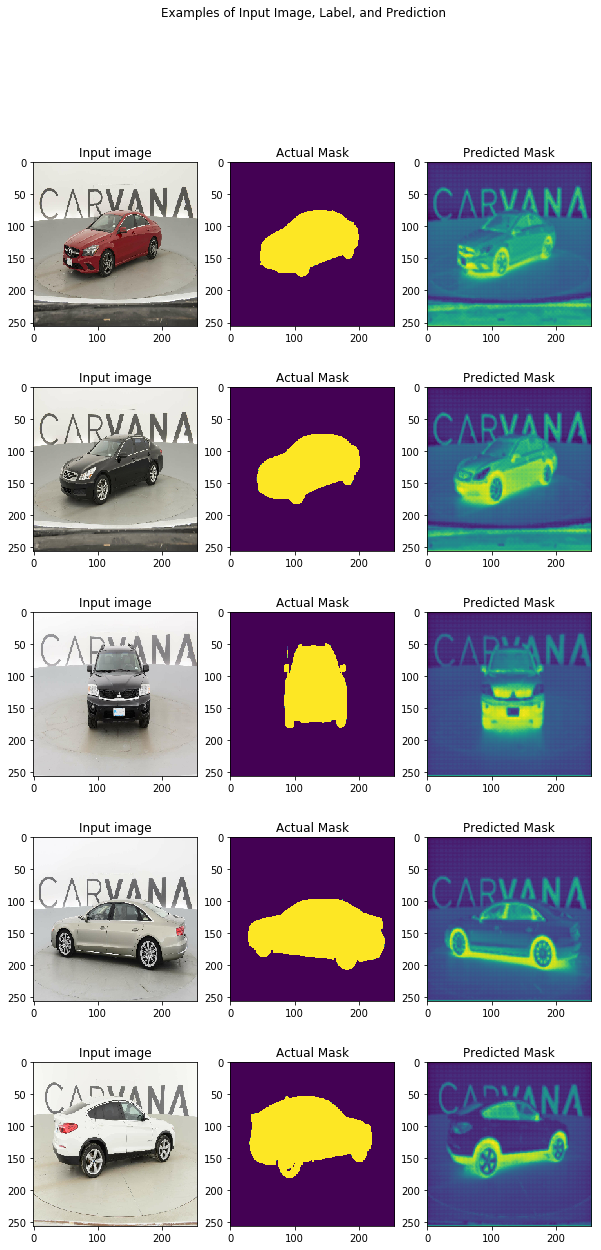

In [38]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

# Key Takeaways
In this tutorial we learned how to train a network to automatically detect and create cutouts of cars from images! 

## Specific concepts that will we covered:
In the process, we hopefully built some practical experience and developed intuition around the following concepts
* [**Functional API**](https://keras.io/getting-started/functional-api-guide/) - we implemented UNet with the Functional API. Functional API gives a lego-like API that allows us to build pretty much any network.  
* **Custom Losses and Metrics** - We implemented custom metrics that allow us to see exactly what we need during training time. In addition, we wrote a custom loss function that is specifically suited to our task.
* **Distributed Learning with [Analytics Zoo](https://analytics-zoo.github.io/)** - We wrapped our keras model with `zoo.tfpark.KerasModel` to support distributed learning. To run this pipeline, we need also prefetch the training data into memory to serialize.
* **Save and load our model** - We saved our best model that we encountered according to our specified metric. When we wanted to perform inference with out best model, we loaded it from disk. Note that saving the model capture more than just the weights of the model: by default, it saves the model architecture, weights, as well as information about the training process such as the state of the optimizer, etc. 